# Exploration of incidents dataset

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def get_connection(schema="build_1_3_0"):
    
    conn = psycopg2.connect("dbname='proj001_lfb' user='postgres' "
                            "host='10.152.234.53'")
    if schema:
        cur = conn.cursor()
        query = "SET search_path TO {}".format(schema)
        cur.execute(query)
        
    return conn

# Import data
Note the code is querying the raw data file in `inputs`. 

In [8]:
conn = get_connection()
qry = ('select * '
           'from inputs.inp_002_01_LFB_Incident_data_from_January_2009_to_December_2012 limit 500;' )
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
data = pd.read_sql(qry, conn)  

In [9]:
data.head(10)

,incidentnumber,dateofcall,calyear,timeofcall,hourofcall,incidentgroup,stopcodedescription,specialservicetype,propertycategory,propertytype,...,easting_rounded,northing_rounded,frs,incidentstationground,firstpumparriving_attendancetime,firstpumparriving_deployedfromstation,secondpumparriving_attendancetime,secondpumparriving_deployedfromstation,numstationswithpumpsattending,numpumpsattending
0,235138081,01-Jan-09,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,528650,176850,London,Battersea,NULL,None,NULL,None,2,2
1,1091,01-Jan-09,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,530450,179050,London,Lambeth,NULL,None,NULL,None,NULL,NULL
2,2091,01-Jan-09,2009,00:03:00,0,Fire,Secondary Fire,None,Outdoor,Road surface/pavement,...,533750,194450,London,Edmonton,NULL,None,NULL,None,1,1
3,3091,01-Jan-09,2009,00:04:27,0,Fire,Secondary Fire,None,Outdoor,Domestic garden (vegetation not equipment),...,507750,182850,London,Hillingdon,NULL,None,NULL,None,1,1
4,5091,01-Jan-09,2009,00:05:39,0,Fire,Secondary Fire,None,Outdoor,Cycle path/public footpath/bridleway,...,531050,185350,London,Holloway,NULL,None,NULL,None,1,2
5,6091,01-Jan-09,2009,00:06:03,0,False Alarm,AFA,None,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,...,529450,185250,London,Kentish Town,NULL,None,NULL,None,1,2
6,8091,01-Jan-09,2009,00:12:31,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,541050,175650,London,Lee Green,NULL,None,NULL,None,1,1
7,9091,01-Jan-09,2009,00:13:42,0,Fire,Secondary Fire,None,Outdoor Structure,Refuse/rubbish tip,...,514550,174950,London,Heston,NULL,None,NULL,None,1,2
8,10091,01-Jan-09,2009,00:14:51,0,Fire,Secondary Fire,None,Outdoor Structure,Small refuse/rubbish container,...,531950,182650,London,Shoreditch,NULL,None,NULL,None,1,1
9,11091,01-Jan-09,2009,00:14:57,0,False Alarm,AFA,None,Other Residential,Student Hall of Residence,...,529950,181750,London,Soho,NULL,None,NULL,None,1,1


About the expected number of days for 4 years

In [10]:
qry = ('select count (distinct dateofcall) '
           'from inputs.inp_002_01_LFB_Incident_data_from_January_2009_to_December_2012;' )
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
data = pd.read_sql(qry, conn)  
data

,count
0,1461


# What types of incident occur?

In [11]:
qry = ('select incidentgroup,count (*) '
           'from inputs.inp_002_01_LFB_Incident_data_from_January_2009_to_December_2012 '
           'group by incidentgroup '
           'order by count(*) desc;' )
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
data = pd.read_sql(qry, conn)  
data

,incidentgroup,count
0,False Alarm,234385
1,Special Service,144987
2,Fire,105684


# How manay incidents over time?

In [12]:
qry = ("select dateofcall,to_date(dateofcall,'DD-Mon-YY') as dateofcall_cln, incidentgroup, count(*) "
           "from inputs.inp_002_01_LFB_Incident_data_from_January_2009_to_December_2012 "
           "group by dateofcall,to_date(dateofcall,'DD-Mon-YY'), incidentgroup "
           "order by dateofcall,to_date(dateofcall,'DD-Mon-YY') asc "
           ";" )

data = pd.read_sql(qry, conn)  
data.head()

,dateofcall,dateofcall_cln,incidentgroup,count
0,01-Apr-09,2009-04-01,False Alarm,171
1,01-Apr-09,2009-04-01,Fire,88
2,01-Apr-09,2009-04-01,Special Service,123
3,01-Apr-10,2010-04-01,False Alarm,194
4,01-Apr-10,2010-04-01,Fire,44


In [13]:
data['dateofcall_cln'] = pd.to_datetime(data['dateofcall_cln'])
data = data.sort_values('dateofcall_cln')
data.head()

,dateofcall,dateofcall_cln,incidentgroup,count
49,01-Jan-09,2009-01-01,Special Service,135
48,01-Jan-09,2009-01-01,False Alarm,165
50,01-Jan-09,2009-01-01,Fire,107
194,02-Jan-09,2009-01-02,Fire,74
192,02-Jan-09,2009-01-02,False Alarm,134


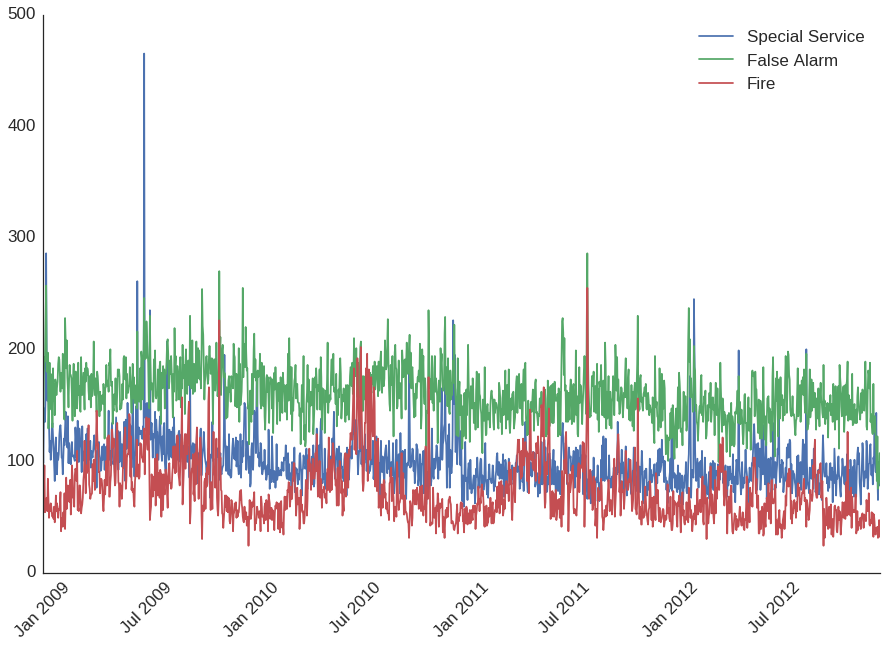

In [14]:
# sns.tsplot(time="dateofcall_cln", value="count", condition="incidentgroup",data=data)
sns.set(style='white', font_scale=1.7)

fig, ax= plt.subplots(figsize=(15,10))
incident_types = data.incidentgroup.unique()

for incident in incident_types:
    subdata = data[data.incidentgroup==incident]
    ax.plot( subdata['dateofcall_cln'], subdata['count'], label=incident)
plt.legend()
sns.despine()
plt.xticks(rotation=45)
plt.show()

# Which were the worst days?

In [15]:
data.sort_values('count', ascending=False).head(5)

,dateofcall,dateofcall_cln,incidentgroup,count
3818,27-Jun-09,2009-06-27,Special Service,465
1170,09-Aug-11,2011-08-09,False Alarm,286
914,07-Jan-09,2009-01-07,Special Service,286
685,05-Nov-09,2009-11-05,False Alarm,270
2088,15-Jun-09,2009-06-15,Special Service,261
